In [69]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


In [70]:
#full lightcast data pull
file_path = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/Analysis/lc_data24.csv"  
df = pd.read_csv(file_path)

#does it look alright?
print(df.head())

#we can get rid of some of these columns
df = df.drop(['Area Bucket', 'Industry Bucket'], axis=1)

#we can drop non-county data
df = df[~df['Area Name'].str.contains("county not reported", case=False, na=False)]

#get that crosswalk in there
file_path_cw = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/GitHub/Economic-Complexity/county20.csv"  
cw = pd.read_csv(file_path_cw)

#merge it up
df = df.merge(cw, left_on="Area", right_on="GEOID", how="left")

#drop the GEOID, it's already represented with "Area"
df = df.drop(['GEOID'], axis=1)


          Area Name Area Bucket  \
0  Adair County, IA     IA - MS   
1  Adair County, IA     IA - MS   
2  Adair County, IA     IA - MS   
3  Adair County, IA     IA - MS   
4  Adair County, IA     IA - MS   

                                       Industry Name Industry Bucket   Area  \
0                                    Crop Production           All 6  19001   
1                                  Animal Production           All 6  19001   
2                            Timber Tract Operations           All 6  19001   
3  Forest Nurseries and Gathering of Forest Products           All 6  19001   
4                                            Logging           All 6  19001   

   Industry  Year        Jobs  
0    111000  2024   61.166300  
1    112000  2024  105.226894  
2    113110  2024    0.000000  
3    113210  2024    0.000000  
4    113310  2024    0.000000  


In [71]:

# Ensure 'Jobs' column is numeric
df['Jobs'] = pd.to_numeric(df['Jobs'], errors='coerce')

# Compute total employment for each industry within each commuting zone
df['Total_Employment'] = df.groupby(['CZ20', 'Industry'])['Jobs'].transform('sum')

# Compute total employment in each commuting zone across all industries
df['Total_CZ_Employment'] = df.groupby('CZ20')['Jobs'].transform('sum')

# Calculate industry's share of total employment in the commuting zone
df['Employment_Share'] = df['Total_Employment'] / df['Total_CZ_Employment']

#collapsed data
df = df[['CZ20', 'Area', 'Area Name', 'Industry', 'Industry Name', 'Jobs', 'Total_CZ_Employment', 'Employment_Share']].drop_duplicates()

# Compute log transformations
df['Log_Total_CZ_Employment'] = np.log(df['Total_CZ_Employment'])
df['Log_Total_CZ_Employment_Squared'] = df['Log_Total_CZ_Employment'] ** 2

In [72]:
def run_ppml_te(df, naics_code):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    
    Parameters:
    df (DataFrame): The dataset containing employment data.
    naics_code (int or str): The 6-digit NAICS code of the industry.
    """

    # Convert NAICS code to string (in case it's stored as int)
    naics_code = str(naics_code)

    # Retrieve the industry name corresponding to the NAICS code
    if naics_code not in df['Industry'].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return

    industry_name = df[df['Industry'].astype(str) == naics_code]['Industry Name'].iloc[0]

    # Filter the dataset for the given NAICS industry
    df_industry = df[df['Industry'].astype(str) == naics_code].copy()

    # Drop missing or infinite values
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the regression formula
    formula = "Jobs ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"

    # Run PPML regression across all zones
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()

    # Print regression summary
    print(model.summary())

    # Plot Jobs vs Log Total Employment for all zones
    plt.figure(figsize=(8, 5))
    plt.scatter(df_industry['Log_Total_CZ_Employment'], np.log1p(df_industry['Jobs']), alpha=0.5, label='Data')

    # Generate predicted values
    df_industry['Predicted_Jobs'] = model.predict(df_industry)

    # Sort values for smooth line
    sorted_df = df_industry.sort_values('Log_Total_CZ_Employment')

    # Plot regression line
    plt.plot(sorted_df['Log_Total_CZ_Employment'], np.log(sorted_df['Predicted_Jobs']), color='red', label='PPML Fit')

    # Labels and title
    plt.xlabel("Log Total Employment in CZ")
    plt.ylabel("Log Employment in Industry in CZ")
    plt.title(f"PPML Regression for {industry_name} (NAICS {naics_code})")
    plt.legend()
    plt.grid(True)
    
    # Prevent y-axis from dropping below zero
    plt.ylim(bottom=0)
    
    # Show plot
    plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Jobs   No. Observations:                 3142
Model:                            GLM   Df Residuals:                     3139
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.3639e+05
Date:                Tue, 11 Mar 2025   Deviance:                   1.6574e+06
Time:                        16:56:30   Pearson chi2:                 8.48e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

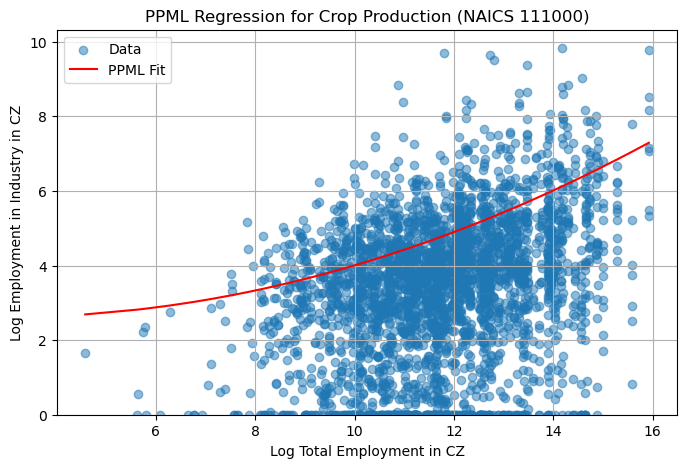

In [75]:
run_ppml_te(df, naics_code=111000)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Jobs   No. Observations:                 3142
Model:                            GLM   Df Residuals:                     3139
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0136e+06
Date:                Tue, 11 Mar 2025   Deviance:                   6.0065e+06
Time:                        12:21:56   Pearson chi2:                 2.04e+07
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

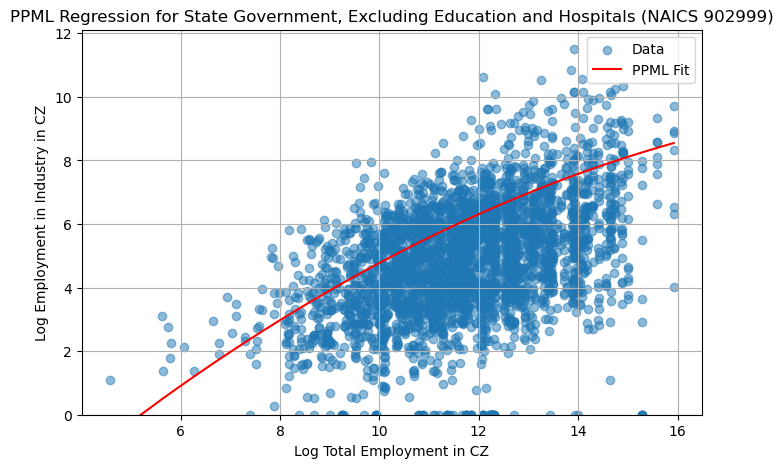

In [41]:
run_ppml_te(df, naics_code=902999)

In [42]:
def run_ppml_se(df, naics_code):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    
    Parameters:
    df (DataFrame): The dataset containing employment data.
    naics_code (int or str): The 6-digit NAICS code of the industry.
    """

    # Convert NAICS code to string (in case it's stored as int)
    naics_code = str(naics_code)

    # Retrieve the industry name corresponding to the NAICS code
    if naics_code not in df['Industry'].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return

    industry_name = df[df['Industry'].astype(str) == naics_code]['Industry Name'].iloc[0]

    # Filter the dataset for the given NAICS industry
    df_industry = df[df['Industry'].astype(str) == naics_code].copy()

    # Drop missing or infinite values
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the regression formula
    formula = "Employment_Share ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"

    # Run PPML regression across all zones
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()

    # Print regression summary
    print(model.summary())

    # Plot Jobs vs Log Total Employment for all zones
    plt.figure(figsize=(8, 5))
    plt.scatter(np.log(df_industry['Total_CZ_Employment']), (df_industry['Employment_Share']), alpha=0.5, label='Data')

    # Generate predicted values
    df_industry['Predicted_Jobs_Sh'] = model.predict(df_industry)

    # Sort values for smooth line
    sorted_df = df_industry.sort_values('Log_Total_CZ_Employment')

    # Plot regression line
    plt.plot(sorted_df['Log_Total_CZ_Employment'], (sorted_df['Predicted_Jobs_Sh']), color='red', label='PPML Fit')

    # Labels and title
    plt.xlabel("Log Total Employment in CZ")
    plt.ylabel("Employment Share in Industry in CZ")
    plt.title(f"PPML Regression for {industry_name} (NAICS {naics_code})")
    plt.legend()
    plt.grid(True)

    
    # Show plot
    plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:       Employment_Share   No. Observations:                 3142
Model:                            GLM   Df Residuals:                     3139
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -289.91
Date:                Tue, 11 Mar 2025   Deviance:                       45.020
Time:                        12:21:59   Pearson chi2:                     72.5
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0006475
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

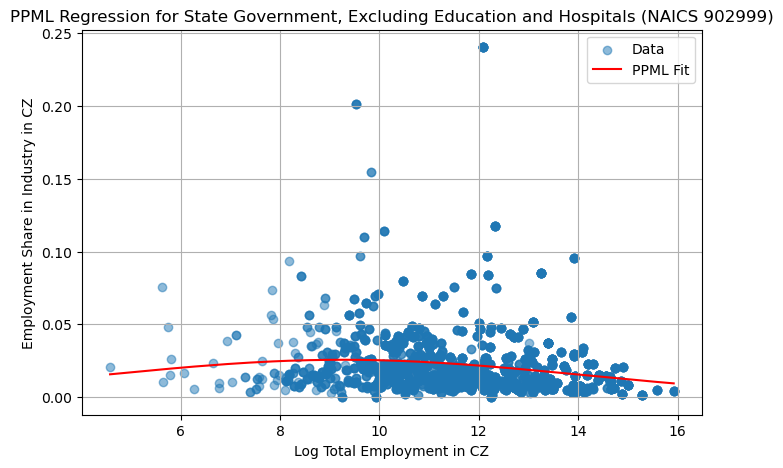

In [43]:
run_ppml_se(df, naics_code=902999)

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Employment_Share   No. Observations:                 3142
Model:                            GLM   Df Residuals:                     3139
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -102.27
Date:                Tue, 11 Mar 2025   Deviance:                       22.705
Time:                        12:22:02   Pearson chi2:                     45.8
No. Iterations:                     5   Pseudo R-squ. (CS):           0.001862
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

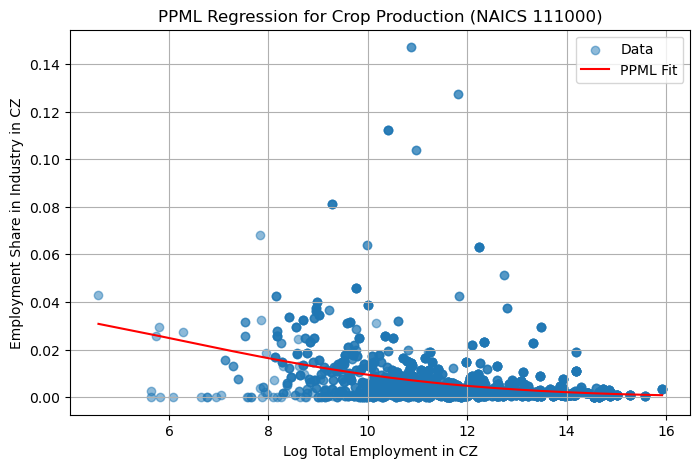

In [44]:
run_ppml_se(df, naics_code=111000)

In [45]:
'''
##############might delete##########################

scaling_coefficients = {}

for naics_code in df['Industry'].astype(str).unique():
    df_industry = df[df['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Jobs ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_CZ_Employment", np.nan)
        beta_2 = model.params.get("Log_Total_CZ_Employment_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept", "Scaling_Coefficient_Beta1", "Beta2"])
df_scaling.reset_index(inplace=True)
df_scaling.rename(columns={"index": "Industry"}, inplace=True)
'''


'\n##############might delete##########################\n\nscaling_coefficients = {}\n\nfor naics_code in df[\'Industry\'].astype(str).unique():\n    df_industry = df[df[\'Industry\'] == naics_code].copy()\n    \n    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print\n\n    if len(df_industry) < 10:\n        continue  # Skip industries with too few data points\n\n    formula = "Jobs ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"\n\n    try:\n        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()\n        \n        # Extract coefficients\n        beta_0 = model.params.get("Intercept", np.nan)  \n        beta_1 = model.params.get("Log_Total_CZ_Employment", np.nan)\n        beta_2 = model.params.get("Log_Total_CZ_Employment_Squared", np.nan)  \n\n        # Store all coefficients\n        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)\n\n    except Exception as e:\n        print

In [46]:
def get_commuting_zone(df, county_name):
    """
    Returns the commuting zone (CZ20) for a given county name.
    
    Parameters:
    df (DataFrame): The dataset containing "Area Name" (county names) and "CZ20" (commuting zones).
    county_name (str): The name of the county to look up.
    
    Returns:
    array or None: The unique commuting zone(s) if found, otherwise None.
    """
    result = df[df["Area Name"].str.contains(county_name, case=False, na=False)]
    return result["CZ20"].unique() if not result.empty else None



county_name = "Larimer County, CO"                            #Fort Collins, CO
larimer = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {larimer}")

county_name = "Yellowstone County, MT"                            #Billings, MT
yellowstone = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {yellowstone}")

county_name = "Gallatin County, MT"                                #Bozeman, MT
gallatin = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {gallatin}")

county_name = "Pennington County, SD"                           #Rapid City, SD
pennington = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {pennington}")

county_name = "Scotts Bluff County, NE"                        #Scottsbluff, NE
scottsbluff = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {scottsbluff}")

county_name = "Bannock County, ID"                               #Pocatello, ID
bannock = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {bannock}")

county_name = "Cache County, UT"                                     #Logan, UT
cache = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {cache}")

Commuting Zone for Larimer County, CO: [84.]
Commuting Zone for Yellowstone County, MT: [327.]
Commuting Zone for Gallatin County, MT: [326.]
Commuting Zone for Pennington County, SD: [479.]
Commuting Zone for Scotts Bluff County, NE: [348.]
Commuting Zone for Bannock County, ID: [131.]
Commuting Zone for Cache County, UT: [139.]


In [47]:
# Combine all commuting zones into a set (removes duplicates)
target_czs = set()

for cz in [larimer, yellowstone, gallatin, pennington, scottsbluff, bannock, cache]:
    if cz is not None:
        if isinstance(cz, np.ndarray):  # Extract value if it's an array
            target_czs.update(cz.tolist())
        else:
            target_czs.add(cz)
            
# Convert to sorted list for readability
target_czs = sorted(target_czs)
print(f"Target Commuting Zones: {target_czs}")




# Filter dataset to only the selected commuting zones
df_filtered = df[df['CZ20'].isin(target_czs)]

# Check if filtering worked
print(df_filtered['CZ20'].unique()) 


Target Commuting Zones: [84.0, 131.0, 139.0, 326.0, 327.0, 348.0, 479.0]
[ 84. 131. 139. 326. 327. 348. 479.]


In [48]:
print(df_filtered.shape)  # Should have at least some rows
print(df_filtered['Industry'].value_counts())


(37880, 10)
Industry
111000    40
518210    40
513140    40
513191    40
513199    40
          ..
333519    40
333611    40
333612    40
333613    40
999999    40
Name: count, Length: 947, dtype: int64


In [49]:
df_filtered['Industry'] = df_filtered['Industry'].astype(str)

C:\Users\ConnorChristensen\AppData\Local\Temp\ipykernel_56800\1663686440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Industry'] = df_filtered['Industry'].astype(str)


In [50]:
'''
def run_ppml_te(df, naics_code):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    
    Parameters:
    df (DataFrame): The dataset containing employment data.
    naics_code (int or str): The 6-digit NAICS code of the industry.
    """

    # Convert NAICS code to string (in case it's stored as int)
    naics_code = str(naics_code)

    # Retrieve the industry name corresponding to the NAICS code
    if naics_code not in df['Industry'].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return

    industry_name = df[df['Industry'].astype(str) == naics_code]['Industry Name'].iloc[0]

    # Filter the dataset for the given NAICS industry
    df_industry = df[df['Industry'].astype(str) == naics_code].copy()

    # Drop missing or infinite values
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the regression formula
    formula = "Jobs ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"

    # Run PPML regression across all zones
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()

    # Print regression summary
    print(model.summary())

    # Plot Jobs vs Log Total Employment for all zones
    plt.figure(figsize=(8, 5))
    plt.scatter(df_industry['Log_Total_CZ_Employment'], np.log1p(df_industry['Jobs']), alpha=0.5, label='Data')

    # Generate predicted values
    df_industry['Predicted_Jobs'] = model.predict(df_industry)

    # Sort values for smooth line
    sorted_df = df_industry.sort_values('Log_Total_CZ_Employment')

    # Plot regression line
    plt.plot(sorted_df['Log_Total_CZ_Employment'], np.log(sorted_df['Predicted_Jobs']), color='red', label='PPML Fit')

    # Labels and title
    plt.xlabel("Log Total Employment in CZ")
    plt.ylabel("Log Employment in Industry in CZ")
    plt.title(f"PPML Regression for {industry_name} (NAICS {naics_code})")
    plt.legend()
    plt.grid(True)
    
    # Prevent y-axis from dropping below zero
    plt.ylim(bottom=0)
    
    # Show plot
    plt.show()

'''
#################################################################
scaling_coefficients = {}

for naics_code in df_filtered['Industry'].astype(str).unique():
    df_industry = df_filtered[df_filtered['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Jobs ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_CZ_Employment", np.nan)
        beta_2 = model.params.get("Log_Total_CZ_Employment_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept", "Scaling_Coefficient_Beta1", "Beta2"])
df_scaling.reset_index(inplace=True)
df_scaling.rename(columns={"index": "Industry"}, inplace=True)


Processing Industry: 111000, Observations: 40
Processing Industry: 112000, Observations: 40
Processing Industry: 113110, Observations: 40
Error processing NAICS 113110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 113210, Observations: 40
Processing Industry: 113310, Observations: 40
Processing Industry: 114111, Observations: 40
Processing Industry: 114112, Observations: 40
Error processing NAICS 114112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 114119, Observations: 40
Error processing NAICS 114119: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 114210, Observations: 40
Processing Industry: 115111, Observations: 40
Error processing NAICS 115111: The first guess on the deviance function returned a nan.  This could

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 115113, Observations: 40
Processing Industry: 115114, Observations: 40
Processing Industry: 115115, Observations: 40
Processing Industry: 115116, Observations: 40
Processing Industry: 115210, Observations: 40
Processing Industry: 115310, Observations: 40
Processing Industry: 211120, Observations: 40
Processing Industry: 211130, Observations: 40
Processing Industry: 212114, Observations: 40
Processing Industry: 212115, Observations: 40
Processing Industry: 212210, Observations: 40
Error processing NAICS 212210: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 212220, Observations: 40
Processing Industry: 212230, Observations: 40
Processing Industry: 212290, Observations: 40
Processing Industry: 212311, Observations: 40
Processing Industry: 212312, Observations: 40
Processing Industry: 212313, Observations: 40
Processing Industry: 212319, Observations: 40
Processing Industry: 2123

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 212322, Observations: 40
Processing Industry: 212323, Observations: 40
Processing Industry: 212390, Observations: 40
Processing Industry: 213111, Observations: 40
Processing Industry: 213112, Observations: 40
Processing Industry: 213113, Observations: 40
Processing Industry: 213114, Observations: 40
Processing Industry: 213115, Observations: 40
Processing Industry: 221111, Observations: 40
Processing Industry: 221112, Observations: 40
Processing Industry: 221113, Observations: 40
Error processing NAICS 221113: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 221114, Observations: 40
Processing Industry: 221115, Observations: 40
Processing Industry: 221116, Observations: 40
Error processing NAICS 221116: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 221117, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 221118, Observations: 40
Processing Industry: 221121, Observations: 40
Processing Industry: 221122, Observations: 40
Processing Industry: 221210, Observations: 40
Processing Industry: 221310, Observations: 40
Processing Industry: 221320, Observations: 40
Processing Industry: 221330, Observations: 40
Error processing NAICS 221330: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 236115, Observations: 40
Processing Industry: 236116, Observations: 40
Processing Industry: 236117, Observations: 40
Processing Industry: 236118, Observations: 40
Processing Industry: 236210, Observations: 40
Processing Industry: 236220, Observations: 40
Processing Industry: 237110, Observations: 40
Processing Industry: 237120, Observations: 40
Processing Industry: 237130, Observations: 40
Processing Industry: 237210, Observations: 40
Processing Industry: 237310, Observations: 40
Processing Industry: 2379

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 311352, Observations: 40
Processing Industry: 311411, Observations: 40
Processing Industry: 311412, Observations: 40
Processing Industry: 311421, Observations: 40
Processing Industry: 311422, Observations: 40
Processing Industry: 311423, Observations: 40
Processing Industry: 311511, Observations: 40
Processing Industry: 311512, Observations: 40
Processing Industry: 311513, Observations: 40
Processing Industry: 311514, Observations: 40
Error processing NAICS 311514: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311520, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\g

Processing Industry: 311611, Observations: 40
Processing Industry: 311612, Observations: 40
Processing Industry: 311613, Observations: 40
Processing Industry: 311615, Observations: 40
Processing Industry: 311710, Observations: 40
Error processing NAICS 311710: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311811, Observations: 40
Processing Industry: 311812, Observations: 40
Processing Industry: 311813, Observations: 40
Error processing NAICS 311813: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311821, Observations: 40
Error processing NAICS 311821: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 311824, Observations: 40
Processing Industry: 311830, Observations: 40
Processing Industry: 311911, Observations: 40
Processing Industry: 311919, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodel

Processing Industry: 314994, Observations: 40
Processing Industry: 314999, Observations: 40
Processing Industry: 315120, Observations: 40
Processing Industry: 315210, Observations: 40
Processing Industry: 315250, Observations: 40
Processing Industry: 315990, Observations: 40
Processing Industry: 316110, Observations: 40
Processing Industry: 316210, Observations: 40
Processing Industry: 316990, Observations: 40
Processing Industry: 321113, Observations: 40
Processing Industry: 321114, Observations: 40
Processing Industry: 321211, Observations: 40
Processing Industry: 321212, Observations: 40
Error processing NAICS 321212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 321215, Observations: 40
Processing Industry: 321219, Observations: 40
Processing Industry: 321911, Observations: 40
Processing Industry: 321912, Observations: 40
Processing Industry: 321918, Observations: 40
Processing Industry: 3219

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 322130, Observations: 40
Error processing NAICS 322130: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322211, Observations: 40
Processing Industry: 322212, Observations: 40
Error processing NAICS 322212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322219, Observations: 40
Error processing NAICS 322219: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322220, Observations: 40
Processing Industry: 322230, Observations: 40
Processing Industry: 322291, Observations: 40
Error processing NAICS 322291: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322299, Observations: 40
Processing Industry: 323111, Observations: 4

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 324191, Observations: 40
Processing Industry: 324199, Observations: 40
Error processing NAICS 324199: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325110, Observations: 40
Processing Industry: 325120, Observations: 40
Processing Industry: 325130, Observations: 40
Processing Industry: 325180, Observations: 40
Processing Industry: 325193, Observations: 40
Processing Industry: 325194, Observations: 40
Error processing NAICS 325194: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325199, Observations: 40
Processing Industry: 325211, Observations: 40
Processing Industry: 325212, Observations: 40
Error processing NAICS 325212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325220, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 325311, Observations: 40
Processing Industry: 325312, Observations: 40
Processing Industry: 325314, Observations: 40
Processing Industry: 325315, Observations: 40
Processing Industry: 325320, Observations: 40
Processing Industry: 325411, Observations: 40
Processing Industry: 325412, Observations: 40
Processing Industry: 325413, Observations: 40
Processing Industry: 325414, Observations: 40
Processing Industry: 325510, Observations: 40
Processing Industry: 325520, Observations: 40
Processing Industry: 325611, Observations: 40
Processing Industry: 325612, Observations: 40
Processing Industry: 325613, Observations: 40
Processing Industry: 325620, Observations: 40
Processing Industry: 325910, Observations: 40
Error processing NAICS 325910: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325920, Observations: 40
Error processing NAICS 325920: The first guess on the deviance function

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 326130, Observations: 40
Processing Industry: 326140, Observations: 40
Processing Industry: 326150, Observations: 40
Processing Industry: 326160, Observations: 40
Processing Industry: 326191, Observations: 40
Error processing NAICS 326191: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 326199, Observations: 40
Processing Industry: 326211, Observations: 40
Error processing NAICS 326211: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 326212, Observations: 40
Processing Industry: 326220, Observations: 40
Processing Industry: 326291, Observations: 40
Processing Industry: 326299, Observations: 40
Processing Industry: 327110, Observations: 40
Processing Industry: 327120, Observations: 40
Error processing NAICS 327120: The first guess on the deviance function returned a nan.  This could be a bou

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodel

Processing Industry: 327390, Observations: 40
Processing Industry: 327410, Observations: 40
Processing Industry: 327420, Observations: 40
Error processing NAICS 327420: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327910, Observations: 40
Error processing NAICS 327910: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327991, Observations: 40
Processing Industry: 327992, Observations: 40
Error processing NAICS 327992: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327993, Observations: 40
Processing Industry: 327999, Observations: 40
Processing Industry: 331110, Observations: 40
Processing Industry: 331210, Observations: 40
Processing Industry: 331221, Observations: 40
Processing Industry: 331222, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 331318, Observations: 40
Error processing NAICS 331318: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331410, Observations: 40
Processing Industry: 331420, Observations: 40
Processing Industry: 331491, Observations: 40
Processing Industry: 331492, Observations: 40
Processing Industry: 331511, Observations: 40
Processing Industry: 331512, Observations: 40
Error processing NAICS 331512: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331513, Observations: 40
Processing Industry: 331523, Observations: 40
Processing Industry: 331524, Observations: 40
Error processing NAICS 331524: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331529, Observations: 40
Processing Industry: 332111, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 332431, Observations: 40
Processing Industry: 332439, Observations: 40
Processing Industry: 332510, Observations: 40
Processing Industry: 332613, Observations: 40
Error processing NAICS 332613: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332618, Observations: 40
Processing Industry: 332710, Observations: 40
Processing Industry: 332721, Observations: 40
Processing Industry: 332722, Observations: 40
Processing Industry: 332811, Observations: 40
Processing Industry: 332812, Observations: 40
Processing Industry: 332813, Observations: 40
Processing Industry: 332911, Observations: 40
Processing Industry: 332912, Observations: 40
Processing Industry: 332913, Observations: 40
Processing Industry: 332919, Observations: 40
Error processing NAICS 332919: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Indus

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 332992, Observations: 40
Processing Industry: 332993, Observations: 40
Error processing NAICS 332993: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332994, Observations: 40
Processing Industry: 332996, Observations: 40
Processing Industry: 332999, Observations: 40
Processing Industry: 333111, Observations: 40
Processing Industry: 333112, Observations: 40
Processing Industry: 333120, Observations: 40
Processing Industry: 333131, Observations: 40
Processing Industry: 333132, Observations: 40
Processing Industry: 333241, Observations: 40
Processing Industry: 333242, Observations: 40
Processing Industry: 333243, Observations: 40
Processing Industry: 333248, Observations: 40
Processing Industry: 333310, Observations: 40
Processing Industry: 333413, Observations: 40
Processing Industry: 333414, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 333415, Observations: 40
Processing Industry: 333511, Observations: 40
Processing Industry: 333514, Observations: 40
Processing Industry: 333515, Observations: 40
Processing Industry: 333517, Observations: 40
Processing Industry: 333519, Observations: 40
Processing Industry: 333611, Observations: 40
Processing Industry: 333612, Observations: 40
Processing Industry: 333613, Observations: 40
Processing Industry: 333618, Observations: 40
Processing Industry: 333912, Observations: 40
Processing Industry: 333914, Observations: 40
Processing Industry: 333921, Observations: 40
Error processing NAICS 333921: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 333922, Observations: 40
Processing Industry: 333923, Observations: 40
Processing Industry: 333924, Observations: 40
Processing Industry: 333991, Observations: 40
Error processing NAICS 333991: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 333992, Observations: 40
Processing Industry: 333993, Observations: 40
Processing Industry: 333994, Observations: 40
Processing Industry: 333995, Observations: 40
Processing Industry: 333996, Observations: 40
Error processing NAICS 333996: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 333998, Observations: 40
Processing Industry: 334111, Observations: 40
Processing Industry: 334112, Observations: 40
Processing Industry: 334118, Observations: 40
Processing Industry: 334210, Observations: 40
Processing Industry: 334220, Observations: 40
Processing Indus

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 335314, Observations: 40
Processing Industry: 335910, Observations: 40
Processing Industry: 335921, Observations: 40
Error processing NAICS 335921: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 335929, Observations: 40
Processing Industry: 335931, Observations: 40
Processing Industry: 335932, Observations: 40
Processing Industry: 335991, Observations: 40
Processing Industry: 335999, Observations: 40
Processing Industry: 336110, Observations: 40
Error processing NAICS 336110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336120, Observations: 40
Error processing NAICS 336120: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336211, Observations: 40
Processing Industry: 336212, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 336330, Observations: 40
Processing Industry: 336340, Observations: 40
Error processing NAICS 336340: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336350, Observations: 40
Processing Industry: 336360, Observations: 40
Processing Industry: 336370, Observations: 40
Error processing NAICS 336370: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336390, Observations: 40
Processing Industry: 336411, Observations: 40
Processing Industry: 336412, Observations: 40
Processing Industry: 336413, Observations: 40
Processing Industry: 336414, Observations: 40
Processing Industry: 336415, Observations: 40
Processing Industry: 336419, Observations: 40
Error processing NAICS 336419: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 337211, Observations: 40
Processing Industry: 337212, Observations: 40
Processing Industry: 337214, Observations: 40
Processing Industry: 337215, Observations: 40
Processing Industry: 337910, Observations: 40
Processing Industry: 337920, Observations: 40
Processing Industry: 339112, Observations: 40
Processing Industry: 339113, Observations: 40
Processing Industry: 339114, Observations: 40
Processing Industry: 339115, Observations: 40
Processing Industry: 339116, Observations: 40
Processing Industry: 339910, Observations: 40
Processing Industry: 339920, Observations: 40
Processing Industry: 339930, Observations: 40
Processing Industry: 339940, Observations: 40
Processing Industry: 339950, Observations: 40
Processing Industry: 339991, Observations: 40
Processing Industry: 339992, Observations: 40
Error processing NAICS 339992: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 339993, Observations: 40
Error processing NAICS 33

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 423520, Observations: 40
Processing Industry: 423610, Observations: 40
Processing Industry: 423620, Observations: 40
Processing Industry: 423690, Observations: 40
Processing Industry: 423710, Observations: 40
Processing Industry: 423720, Observations: 40
Processing Industry: 423730, Observations: 40
Processing Industry: 423740, Observations: 40
Processing Industry: 423810, Observations: 40
Processing Industry: 423820, Observations: 40
Processing Industry: 423830, Observations: 40
Processing Industry: 423840, Observations: 40
Processing Industry: 423850, Observations: 40
Processing Industry: 423860, Observations: 40
Processing Industry: 423910, Observations: 40
Processing Industry: 423920, Observations: 40
Processing Industry: 423930, Observations: 40
Processing Industry: 423940, Observations: 40
Processing Industry: 423990, Observations: 40
Processing Industry: 424110, Observations: 40
Processing Industry: 424120, Observations: 40
Processing Industry: 424130, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 483112, Observations: 40
Error processing NAICS 483112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 483113, Observations: 40
Error processing NAICS 483113: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 483114, Observations: 40
Error processing NAICS 483114: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 483211, Observations: 40
Processing Industry: 483212, Observations: 40
Processing Industry: 484110, Observations: 40
Processing Industry: 484121, Observations: 40
Processing Industry: 484122, Observations: 40
Processing Industry: 484210, Observations: 40
Processing Industry: 484220, Observations: 40
Processing Industry: 484230, Observations: 40
Processing Industry: 485111, Observations: 40
Error p

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 487210, Observations: 40
Processing Industry: 487990, Observations: 40
Processing Industry: 488111, Observations: 40
Processing Industry: 488119, Observations: 40
Processing Industry: 488190, Observations: 40
Processing Industry: 488210, Observations: 40
Processing Industry: 488310, Observations: 40
Error processing NAICS 488310: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488320, Observations: 40
Error processing NAICS 488320: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488330, Observations: 40
Error processing NAICS 488330: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488390, Observations: 40
Error processing NAICS 488390: The first guess on the deviance function returned a nan.  This could

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 493110, Observations: 40
Processing Industry: 493120, Observations: 40
Processing Industry: 493130, Observations: 40
Processing Industry: 493190, Observations: 40
Processing Industry: 512110, Observations: 40
Processing Industry: 512120, Observations: 40
Processing Industry: 512131, Observations: 40
Processing Industry: 512132, Observations: 40
Processing Industry: 512191, Observations: 40
Processing Industry: 512199, Observations: 40
Processing Industry: 512230, Observations: 40
Processing Industry: 512240, Observations: 40
Processing Industry: 512250, Observations: 40
Processing Industry: 512290, Observations: 40
Processing Industry: 513110, Observations: 40
Processing Industry: 513120, Observations: 40
Processing Industry: 513130, Observations: 40
Processing Industry: 513140, Observations: 40
Processing Industry: 513191, Observations: 40
Error processing NAICS 513191: The first guess on the deviance function returned a nan.  This could be a boundary  problem and

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 518210, Observations: 40
Processing Industry: 519210, Observations: 40
Processing Industry: 519290, Observations: 40
Processing Industry: 521110, Observations: 40
Processing Industry: 522110, Observations: 40
Processing Industry: 522130, Observations: 40
Processing Industry: 522180, Observations: 40
Processing Industry: 522210, Observations: 40
Processing Industry: 522220, Observations: 40
Processing Industry: 522291, Observations: 40
Processing Industry: 522292, Observations: 40
Processing Industry: 522299, Observations: 40
Processing Industry: 522310, Observations: 40
Processing Industry: 522320, Observations: 40
Processing Industry: 522390, Observations: 40
Processing Industry: 523150, Observations: 40
Processing Industry: 523160, Observations: 40
Processing Industry: 523210, Observations: 40
Processing Industry: 523910, Observations: 40
Processing Industry: 523940, Observations: 40
Processing Industry: 523991, Observations: 40
Processing Industry: 523999, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 611512, Observations: 40
Processing Industry: 611513, Observations: 40
Processing Industry: 611519, Observations: 40
Processing Industry: 611610, Observations: 40
Processing Industry: 611620, Observations: 40
Processing Industry: 611630, Observations: 40
Processing Industry: 611691, Observations: 40
Processing Industry: 611692, Observations: 40
Processing Industry: 611699, Observations: 40
Processing Industry: 611710, Observations: 40
Processing Industry: 621111, Observations: 40
Processing Industry: 621112, Observations: 40
Processing Industry: 621210, Observations: 40
Processing Industry: 621310, Observations: 40
Processing Industry: 621320, Observations: 40
Processing Industry: 621330, Observations: 40
Processing Industry: 621340, Observations: 40
Processing Industry: 621391, Observations: 40
Processing Industry: 621399, Observations: 40
Processing Industry: 621410, Observations: 40
Processing Industry: 621420, Observations: 40
Processing Industry: 621491, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


In [51]:
df_filtered = df_filtered.merge(df_scaling, on="Industry", how="left")

# Compute expected employment using the scaling model
df_filtered['Expected_Jobs'] = np.exp(
    df_filtered['Intercept'] + 
    df_filtered['Scaling_Coefficient_Beta1'] * df_filtered['Log_Total_CZ_Employment'] + 
    df_filtered['Beta2'] * df_filtered['Log_Total_CZ_Employment_Squared']
)

# Compute employment deviation (actual - expected)
df_filtered['Employment_Deviation'] = df_filtered['Jobs'] - df_filtered['Expected_Jobs']

# Display the top industries with the highest deviations
df_filtered.sort_values(by="Employment_Deviation", ascending=False).head(10)

,CZ20,Area,Area Name,Industry,Industry Name,Jobs,Total_CZ_Employment,Employment_Share,Log_Total_CZ_Employment,Log_Total_CZ_Employment_Squared,Intercept,Scaling_Coefficient_Beta1,Beta2,Expected_Jobs,Employment_Deviation
29350,131.0,16023,"Butte County, ID",541715,"Research and Development in the Physical, Engi...",7197.041530,158324.310709,0.047078,11.972401,143.338381,-613.232142,101.608568,-4.162997,698.599042,6498.442488
36933,326.0,30049,"Lewis and Clark County, MT",902999,"State Government, Excluding Education and Hosp...",6410.083333,119739.967157,0.058592,11.693078,136.728067,183.030125,-30.251191,1.292122,391.502622,6018.580711
34671,327.0,30111,"Yellowstone County, MT",622110,General Medical and Surgical Hospitals,6499.416667,95582.921444,0.071991,11.467749,131.509277,-38.047732,7.081216,-0.279445,606.830178,5892.586489
36037,84.0,8069,"Larimer County, CO",902612,"Colleges, Universities, and Professional Schoo...",9306.833333,303165.691624,0.035909,12.622035,159.315762,108.383111,-19.097366,0.883818,3434.502115,5872.331218
36039,84.0,8069,"Larimer County, CO",902622,Hospitals (State Government),8097.750000,303165.691624,0.026711,12.622035,159.315762,-7506.568968,1216.688272,-49.226843,2699.250010,5398.499990
36789,326.0,30031,"Gallatin County, MT",902612,"Colleges, Universities, and Professional Schoo...",4350.500000,119739.967157,0.037909,11.693078,136.728067,108.383111,-19.097366,0.883818,371.983411,3978.516589
37823,139.0,49005,"Cache County, UT",902612,"Colleges, Universities, and Professional Schoo...",3878.666667,92918.977464,0.041895,11.439483,130.861775,108.383111,-19.097366,0.883818,264.304934,3614.361733
32475,84.0,8069,"Larimer County, CO",722511,Full-Service Restaurants,6940.416667,303165.691624,0.035454,12.622035,159.315762,156.726567,-26.530598,1.169181,3379.096722,3561.319945
37877,348.0,56021,"Laramie County, WY",903622,Hospitals (Local Government),4191.686108,67176.227307,0.067052,11.115075,123.544886,768.218440,-128.024093,5.352871,692.880398,3498.805710
33904,326.0,30031,"Gallatin County, MT",721110,Hotels (except Casino Hotels) and Motels,3809.333333,119739.967157,0.041785,11.693078,136.728067,-15.203105,2.826608,-0.087273,370.891268,3438.442065


In [64]:
#full lightcast data pull
file_path = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/Analysis/lc_data24.csv"  
df = pd.read_csv(file_path)

#does it look alright?
print(df.head())

#we can get rid of some of these columns
df = df.drop(['Area Bucket', 'Industry Bucket'], axis=1)

#we can drop non-county data
df = df[~df['Area Name'].str.contains("county not reported", case=False, na=False)]

#get that crosswalk in there
file_path_cw = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/GitHub/Economic-Complexity/county20.csv"  
cw = pd.read_csv(file_path_cw)

#merge it up
df = df.merge(cw, left_on="Area", right_on="GEOID", how="left")

#drop the GEOID, it's already represented with "Area"
df = df.drop(['GEOID'], axis=1)

          Area Name Area Bucket  \
0  Adair County, IA     IA - MS   
1  Adair County, IA     IA - MS   
2  Adair County, IA     IA - MS   
3  Adair County, IA     IA - MS   
4  Adair County, IA     IA - MS   

                                       Industry Name Industry Bucket   Area  \
0                                    Crop Production           All 6  19001   
1                                  Animal Production           All 6  19001   
2                            Timber Tract Operations           All 6  19001   
3  Forest Nurseries and Gathering of Forest Products           All 6  19001   
4                                            Logging           All 6  19001   

   Industry  Year        Jobs  
0    111000  2024   61.166300  
1    112000  2024  105.226894  
2    113110  2024    0.000000  
3    113210  2024    0.000000  
4    113310  2024    0.000000  


In [65]:
# Ensure 'Jobs' column is numeric
df['Jobs'] = pd.to_numeric(df['Jobs'], errors='coerce')

# Compute total employment for each industry within each commuting zone
df['Total_Employment'] = df.groupby(['CZ20', 'Industry'])['Jobs'].transform('sum')

# Compute total employment in each commuting zone across all industries
df['Total_CZ_Employment'] = df.groupby('CZ20')['Jobs'].transform('sum')

# Calculate industry's share of total employment in the commuting zone
df['Employment_Share'] = df['Total_Employment'] / df['Total_CZ_Employment']

#collapsed data
df = df[['CZ20', 'Area', 'Area Name', 'Industry', 'Industry Name', 'Jobs', 'Total_CZ_Employment', 'Employment_Share']].drop_duplicates()

# Compute log transformations
df['Log_Total_CZ_Employment'] = np.log(df['Total_CZ_Employment'])
df['Log_Total_CZ_Employment_Squared'] = df['Log_Total_CZ_Employment'] ** 2

In [66]:
'''
#NEW
df['Industry'] = df_filtered['Industry'].astype(str)
'''

In [67]:
'''
#NEW

scaling_coefficients = {}

for naics_code in df['Industry'].astype(str).unique():
    df_industry = df[df['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Employment_Share ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_CZ_Employment", np.nan)
        beta_2 = model.params.get("Log_Total_CZ_Employment_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept", "Scaling_Coefficient_Beta1", "Beta2"])
df_scaling.reset_index(inplace=True)
df_scaling.rename(columns={"index": "Industry"}, inplace=True)
'''

Processing Industry: nan, Observations: 0
Processing Industry: 111000, Observations: 40
Processing Industry: 112000, Observations: 40
Processing Industry: 113110, Observations: 40
Error processing NAICS 113110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 113210, Observations: 40
Processing Industry: 113310, Observations: 40
Processing Industry: 114111, Observations: 40
Processing Industry: 114112, Observations: 40
Error processing NAICS 114112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 114119, Observations: 40
Error processing NAICS 114119: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 114210, Observations: 40
Processing Industry: 115111, Observations: 40
Error processing NAICS 115111: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 115112, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 115113, Observations: 40
Processing Industry: 115114, Observations: 40
Processing Industry: 115115, Observations: 40
Processing Industry: 115116, Observations: 40
Processing Industry: 115210, Observations: 40
Processing Industry: 115310, Observations: 40
Error processing NAICS 115310: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 211120, Observations: 40
Processing Industry: 211130, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Processing Industry: 212114, Observations: 40
Processing Industry: 212115, Observations: 40
Processing Industry: 212210, Observations: 40
Error processing NAICS 212210: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 212220, Observations: 40
Processing Industry: 212230, Observations: 40
Processing Industry: 212290, Observations: 40
Processing Industry: 212311, Observations: 40
Processing Industry: 212312, Observations: 40
Processing Industry: 212313, Observations: 40
Processing Industry: 212319, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 212321, Observations: 40
Processing Industry: 212322, Observations: 40
Processing Industry: 212323, Observations: 40
Processing Industry: 212390, Observations: 40
Processing Industry: 213111, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 213112, Observations: 40
Processing Industry: 213113, Observations: 40
Processing Industry: 213114, Observations: 40
Processing Industry: 213115, Observations: 40
Processing Industry: 221111, Observations: 40
Processing Industry: 221112, Observations: 40
Processing Industry: 221113, Observations: 40
Error processing NAICS 221113: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 221114, Observations: 40
Processing Industry: 221115, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_mod

Processing Industry: 221116, Observations: 40
Error processing NAICS 221116: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 221117, Observations: 40
Processing Industry: 221118, Observations: 40
Processing Industry: 221121, Observations: 40
Processing Industry: 221122, Observations: 40
Processing Industry: 221210, Observations: 40
Processing Industry: 221310, Observations: 40
Processing Industry: 221320, Observations: 40
Processing Industry: 221330, Observations: 40
Error processing NAICS 221330: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 236115, Observations: 40
Processing Industry: 236116, Observations: 40
Processing Industry: 236117, Observations: 40
Processing Industry: 236118, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 236210, Observations: 40
Processing Industry: 236220, Observations: 40
Processing Industry: 237110, Observations: 40
Processing Industry: 237120, Observations: 40
Processing Industry: 237130, Observations: 40
Processing Industry: 237210, Observations: 40
Processing Industry: 237310, Observations: 40
Processing Industry: 237990, Observations: 40
Processing Industry: 238110, Observations: 40
Processing Industry: 238120, Observations: 40
Processing Industry: 238130, Observations: 40
Processing Industry: 238140, Observations: 40
Processing Industry: 238150, Observations: 40
Processing Industry: 238160, Observations: 40
Processing Industry: 238170, Observations: 40
Processing Industry: 238190, Observations: 40
Processing Industry: 238210, Observations: 40
Processing Industry: 238220, Observations: 40
Processing Industry: 238290, Observations: 40
Processing Industry: 238310, Observations: 40
Processing Industry: 238320, Observations: 40
Processing Industry: 238330, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 311119, Observations: 40
Processing Industry: 311211, Observations: 40
Processing Industry: 311212, Observations: 40
Error processing NAICS 311212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311213, Observations: 40
Processing Industry: 311221, Observations: 40
Processing Industry: 311224, Observations: 40
Error processing NAICS 311224: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311225, Observations: 40
Error processing NAICS 311225: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 311230, Observations: 40
Processing Industry: 311313, Observations: 40
Processing Industry: 311314, Observations: 40
Error processing NAICS 311314: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311340, Observations: 40
Processing Industry: 311351, Observations: 40
Processing Industry: 311352, Observations: 40
Processing Industry: 311411, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 311412, Observations: 40
Processing Industry: 311421, Observations: 40
Processing Industry: 311422, Observations: 40
Processing Industry: 311423, Observations: 40
Processing Industry: 311511, Observations: 40
Processing Industry: 311512, Observations: 40
Processing Industry: 311513, Observations: 40
Processing Industry: 311514, Observations: 40
Error processing NAICS 311514: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311520, Observations: 40
Processing Industry: 311611, Observations: 40
Processing Industry: 311612, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 311613, Observations: 40
Processing Industry: 311615, Observations: 40
Processing Industry: 311710, Observations: 40
Error processing NAICS 311710: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.p

Processing Industry: 311811, Observations: 40
Processing Industry: 311812, Observations: 40
Processing Industry: 311813, Observations: 40
Error processing NAICS 311813: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311821, Observations: 40
Error processing NAICS 311821: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 311824, Observations: 40
Processing Industry: 311830, Observations: 40
Processing Industry: 311911, Observations: 40
Processing Industry: 311919, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 311920, Observations: 40
Processing Industry: 311930, Observations: 40
Error processing NAICS 311930: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311941, Observations: 40
Processing Industry: 311942, Observations: 40
Processing Industry: 311991, Observations: 40
Processing Industry: 311999, Observations: 40
Processing Industry: 312111, Observations: 40
Processing Industry: 312112, Observations: 40
Processing Industry: 312113, Observations: 40
Processing Industry: 312120, Observations: 40
Processing Industry: 312130, Observations: 40
Processing Industry: 312140, Observations: 40
Processing Industry: 312230, Observations: 40
Processing Industry: 313110, Observations: 40
Processing Industry: 313210, Observations: 40
Error processing NAICS 313210: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Indus

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 313240, Observations: 40
Error processing NAICS 313240: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 313310, Observations: 40
Processing Industry: 313320, Observations: 40
Error processing NAICS 313320: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 314110, Observations: 40
Error processing NAICS 314110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 314120, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 314910, Observations: 40
Processing Industry: 314994, Observations: 40
Processing Industry: 314999, Observations: 40
Processing Industry: 315120, Observations: 40
Processing Industry: 315210, Observations: 40
Processing Industry: 315250, Observations: 40
Processing Industry: 315990, Observations: 40
Processing Industry: 316110, Observations: 40
Processing Industry: 316210, Observations: 40
Processing Industry: 316990, Observations: 40
Processing Industry: 321113, Observations: 40
Processing Industry: 321114, Observations: 40
Processing Industry: 321211, Observations: 40
Processing Industry: 321212, Observations: 40
Error processing NAICS 321212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 321215, Observations: 40
Processing Industry: 321219, Observations: 40
Processing Industry: 321911, Observations: 40
Processing Industry: 321912, Observations: 40
Processing Industry: 3219

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 321920, Observations: 40
Processing Industry: 321991, Observations: 40
Processing Industry: 321992, Observations: 40
Processing Industry: 321999, Observations: 40
Processing Industry: 322110, Observations: 40
Error processing NAICS 322110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322120, Observations: 40
Processing Industry: 322130, Observations: 40
Error processing NAICS 322130: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322211, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 322212, Observations: 40
Error processing NAICS 322212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322219, Observations: 40
Error processing NAICS 322219: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322220, Observations: 40
Processing Industry: 322230, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 322291, Observations: 40
Error processing NAICS 322291: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322299, Observations: 40
Processing Industry: 323111, Observations: 40
Processing Industry: 323113, Observations: 40
Processing Industry: 323117, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 323120, Observations: 40
Processing Industry: 324110, Observations: 40
Processing Industry: 324121, Observations: 40
Processing Industry: 324122, Observations: 40
Processing Industry: 324191, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 324199, Observations: 40
Error processing NAICS 324199: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325110, Observations: 40
Processing Industry: 325120, Observations: 40
Processing Industry: 325130, Observations: 40
Processing Industry: 325180, Observations: 40
Processing Industry: 325193, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 325194, Observations: 40
Error processing NAICS 325194: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325199, Observations: 40
Processing Industry: 325211, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 325212, Observations: 40
Error processing NAICS 325212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325220, Observations: 40
Processing Industry: 325311, Observations: 40
Processing Industry: 325312, Observations: 40
Processing Industry: 325314, Observations: 40
Processing Industry: 325315, Observations: 40
Processing Industry: 325320, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 325411, Observations: 40
Processing Industry: 325412, Observations: 40
Processing Industry: 325413, Observations: 40
Processing Industry: 325414, Observations: 40
Processing Industry: 325510, Observations: 40
Processing Industry: 325520, Observations: 40
Processing Industry: 325611, Observations: 40
Processing Industry: 325612, Observations: 40
Processing Industry: 325613, Observations: 40
Processing Industry: 325620, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 325910, Observations: 40
Error processing NAICS 325910: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325920, Observations: 40
Error processing NAICS 325920: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325991, Observations: 40
Processing Industry: 325992, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_mod

Processing Industry: 325998, Observations: 40
Processing Industry: 326111, Observations: 40
Processing Industry: 326112, Observations: 40
Error processing NAICS 326112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 326113, Observations: 40
Processing Industry: 326121, Observations: 40
Processing Industry: 326122, Observations: 40
Processing Industry: 326130, Observations: 40
Processing Industry: 326140, Observations: 40
Processing Industry: 326150, Observations: 40
Processing Industry: 326160, Observations: 40
Processing Industry: 326191, Observations: 40
Error processing NAICS 326191: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 326199, Observations: 40
Processing Industry: 326211, Observations: 40
Error processing NAICS 326211: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 326212, Observations: 40
Processing Industry: 326220, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 326291, Observations: 40
Processing Industry: 326299, Observations: 40
Processing Industry: 327110, Observations: 40
Processing Industry: 327120, Observations: 40
Error processing NAICS 327120: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 327211, Observations: 40
Error processing NAICS 327211: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327212, Observations: 40
Processing Industry: 327213, Observations: 40
Processing Industry: 327215, Observations: 40
Processing Industry: 327310, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 327320, Observations: 40
Processing Industry: 327331, Observations: 40
Processing Industry: 327332, Observations: 40
Processing Industry: 327390, Observations: 40
Processing Industry: 327410, Observations: 40
Processing Industry: 327420, Observations: 40
Error processing NAICS 327420: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327910, Observations: 40
Error processing NAICS 327910: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 327991, Observations: 40
Processing Industry: 327992, Observations: 40
Error processing NAICS 327992: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327993, Observations: 40
Processing Industry: 327999, Observations: 40
Processing Industry: 331110, Observations: 40
Processing Industry: 331210, Observations: 40
Processing Industry: 331221, Observations: 40
Processing Industry: 331222, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 331313, Observations: 40
Processing Industry: 331314, Observations: 40
Error processing NAICS 331314: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331315, Observations: 40
Processing Industry: 331318, Observations: 40
Error processing NAICS 331318: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331410, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 331420, Observations: 40
Processing Industry: 331491, Observations: 40
Processing Industry: 331492, Observations: 40
Processing Industry: 331511, Observations: 40
Processing Industry: 331512, Observations: 40
Error processing NAICS 331512: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331513, Observations: 40
Processing Industry: 331523, Observations: 40
Processing Industry: 331524, Observations: 40
Error processing NAICS 331524: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331529, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 332111, Observations: 40
Processing Industry: 332112, Observations: 40
Error processing NAICS 332112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 332114, Observations: 40
Processing Industry: 332117, Observations: 40
Processing Industry: 332119, Observations: 40
Processing Industry: 332215, Observations: 40
Processing Industry: 332216, Observations: 40
Processing Industry: 332311, Observations: 40
Processing Industry: 332312, Observations: 40
Processing Industry: 332313, Observations: 40
Processing Industry: 332321, Observations: 40
Processing Industry: 332322, Observations: 40
Processing Industry: 332323, Observations: 40
Processing Industry: 332410, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 332420, Observations: 40
Processing Industry: 332431, Observations: 40
Processing Industry: 332439, Observations: 40
Processing Industry: 332510, Observations: 40
Processing Industry: 332613, Observations: 40
Error processing NAICS 332613: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 332618, Observations: 40
Processing Industry: 332710, Observations: 40
Processing Industry: 332721, Observations: 40
Processing Industry: 332722, Observations: 40
Processing Industry: 332811, Observations: 40
Processing Industry: 332812, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 332813, Observations: 40
Processing Industry: 332911, Observations: 40
Processing Industry: 332912, Observations: 40
Processing Industry: 332913, Observations: 40
Processing Industry: 332919, Observations: 40
Error processing NAICS 332919: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 332991, Observations: 40
Error processing NAICS 332991: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332992, Observations: 40
Processing Industry: 332993, Observations: 40
Error processing NAICS 332993: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332994, Observations: 40
Processing Industry: 332996, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 332999, Observations: 40
Processing Industry: 333111, Observations: 40
Processing Industry: 333112, Observations: 40
Processing Industry: 333120, Observations: 40
Processing Industry: 333131, Observations: 40
Processing Industry: 333132, Observations: 40
Processing Industry: 333241, Observations: 40
Processing Industry: 333242, Observations: 40
Processing Industry: 333243, Observations: 40
Processing Industry: 333248, Observations: 40
Processing Industry: 333310, Observations: 40
Processing Industry: 333413, Observations: 40
Processing Industry: 333414, Observations: 40
Processing Industry: 333415, Observations: 40
Processing Industry: 333511, Observations: 40
Processing Industry: 333514, Observations: 40
Processing Industry: 333515, Observations: 40
Processing Industry: 333517, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Error processing NAICS 333517: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 333519, Observations: 40
Processing Industry: 333611, Observations: 40
Processing Industry: 333612, Observations: 40
Processing Industry: 333613, Observations: 40
Processing Industry: 333618, Observations: 40
Processing Industry: 333912, Observations: 40
Processing Industry: 333914, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 333921, Observations: 40
Error processing NAICS 333921: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 333922, Observations: 40
Processing Industry: 333923, Observations: 40
Processing Industry: 333924, Observations: 40
Processing Industry: 333991, Observations: 40
Error processing NAICS 333991: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 333992, Observations: 40
Processing Industry: 333993, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 333994, Observations: 40
Processing Industry: 333995, Observations: 40
Processing Industry: 333996, Observations: 40
Error processing NAICS 333996: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 333998, Observations: 40
Processing Industry: 334111, Observations: 40
Processing Industry: 334112, Observations: 40
Processing Industry: 334118, Observations: 40
Processing Industry: 334210, Observations: 40
Processing Industry: 334220, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 334290, Observations: 40
Processing Industry: 334310, Observations: 40
Processing Industry: 334412, Observations: 40
Processing Industry: 334413, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Processing Industry: 334416, Observations: 40
Processing Industry: 334417, Observations: 40
Processing Industry: 334418, Observations: 40
Processing Industry: 334419, Observations: 40
Processing Industry: 334510, Observations: 40
Processing Industry: 334511, Observations: 40
Processing Industry: 334512, Observations: 40
Processing Industry: 334513, Observations: 40
Processing Industry: 334514, Observations: 40
Processing Industry: 334515, Observations: 40
Processing Industry: 334516, Observations: 40
Processing Industry: 334517, Observations: 40
Error processing NAICS 334517: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 334519, Observations: 40
Processing Industry: 334610, Observations: 40
Processing Industry: 335131, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 335132, Observations: 40
Processing Industry: 335139, Observations: 40
Processing Industry: 335210, Observations: 40
Processing Industry: 335220, Observations: 40
Error processing NAICS 335220: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 335311, Observations: 40
Processing Industry: 335312, Observations: 40
Processing Industry: 335313, Observations: 40
Processing Industry: 335314, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 335910, Observations: 40
Processing Industry: 335921, Observations: 40
Error processing NAICS 335921: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 335929, Observations: 40
Processing Industry: 335931, Observations: 40
Processing Industry: 335932, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 335991, Observations: 40
Processing Industry: 335999, Observations: 40
Processing Industry: 336110, Observations: 40
Error processing NAICS 336110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336120, Observations: 40
Error processing NAICS 336120: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336211, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 336212, Observations: 40
Processing Industry: 336213, Observations: 40
Processing Industry: 336214, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Processing Industry: 336310, Observations: 40
Processing Industry: 336320, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 336330, Observations: 40
Processing Industry: 336340, Observations: 40
Error processing NAICS 336340: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336350, Observations: 40
Processing Industry: 336360, Observations: 40
Processing Industry: 336370, Observations: 40
Error processing NAICS 336370: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336390, Observations: 40
Processing Industry: 336411, Observations: 40
Processing Industry: 336412, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 336413, Observations: 40
Processing Industry: 336414, Observations: 40
Processing Industry: 336415, Observations: 40
Processing Industry: 336419, Observations: 40
Error processing NAICS 336419: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336510, Observations: 40
Error processing NAICS 336510: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336611, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 336612, Observations: 40
Processing Industry: 336991, Observations: 40
Processing Industry: 336992, Observations: 40
Error processing NAICS 336992: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336999, Observations: 40
Processing Industry: 337110, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 337121, Observations: 40
Processing Industry: 337122, Observations: 40
Processing Industry: 337126, Observations: 40
Processing Industry: 337127, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Processing Industry: 337211, Observations: 40
Processing Industry: 337212, Observations: 40
Processing Industry: 337214, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 337215, Observations: 40
Processing Industry: 337910, Observations: 40
Processing Industry: 337920, Observations: 40
Processing Industry: 339112, Observations: 40
Processing Industry: 339113, Observations: 40
Processing Industry: 339114, Observations: 40
Processing Industry: 339115, Observations: 40
Processing Industry: 339116, Observations: 40
Processing Industry: 339910, Observations: 40
Processing Industry: 339920, Observations: 40
Processing Industry: 339930, Observations: 40
Processing Industry: 339940, Observations: 40
Processing Industry: 339950, Observations: 40
Processing Industry: 339991, Observations: 40
Processing Industry: 339992, Observations: 40
Error processing NAICS 339992: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 339993, Observations: 40
Error processing NAICS 339993: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Indus

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)

Processing Industry: 339999, Observations: 40
Processing Industry: 423110, Observations: 40
Processing Industry: 423120, Observations: 40
Processing Industry: 423130, Observations: 40
Processing Industry: 423140, Observations: 40
Processing Industry: 423210, Observations: 40
Processing Industry: 423220, Observations: 40
Processing Industry: 423310, Observations: 40
Processing Industry: 423320, Observations: 40
Processing Industry: 423330, Observations: 40
Processing Industry: 423390, Observations: 40
Processing Industry: 423410, Observations: 40
Processing Industry: 423420, Observations: 40
Processing Industry: 423430, Observations: 40
Processing Industry: 423440, Observations: 40
Processing Industry: 423450, Observations: 40
Processing Industry: 423460, Observations: 40
Processing Industry: 423490, Observations: 40
Processing Industry: 423510, Observations: 40
Processing Industry: 423520, Observations: 40
Processing Industry: 423610, Observations: 40
Processing Industry: 423620, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 423690, Observations: 40
Processing Industry: 423710, Observations: 40
Processing Industry: 423720, Observations: 40
Processing Industry: 423730, Observations: 40
Processing Industry: 423740, Observations: 40
Processing Industry: 423810, Observations: 40
Processing Industry: 423820, Observations: 40
Processing Industry: 423830, Observations: 40
Processing Industry: 423840, Observations: 40
Processing Industry: 423850, Observations: 40
Processing Industry: 423860, Observations: 40
Processing Industry: 423910, Observations: 40
Processing Industry: 423920, Observations: 40
Processing Industry: 423930, Observations: 40
Processing Industry: 423940, Observations: 40
Processing Industry: 423990, Observations: 40
Processing Industry: 424110, Observations: 40
Processing Industry: 424120, Observations: 40
Processing Industry: 424130, Observations: 40
Processing Industry: 424210, Observations: 40
Processing Industry: 424310, Observations: 40
Processing Industry: 424340, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 483113, Observations: 40
Error processing NAICS 483113: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 483114, Observations: 40
Error processing NAICS 483114: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 483211, Observations: 40
Processing Industry: 483212, Observations: 40
Processing Industry: 484110, Observations: 40
Processing Industry: 484121, Observations: 40
Processing Industry: 484122, Observations: 40
Processing Industry: 484210, Observations: 40
Processing Industry: 484220, Observations: 40
Processing Industry: 484230, Observations: 40
Processing Industry: 485111, Observations: 40
Error processing NAICS 485111: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 485112, Observations: 40
Error processing NAICS 485112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 485113, Observations: 40
Processing Industry: 485119, Observations: 40
Processing Industry: 485210, Observations: 40
Processing Industry: 485310, Observations: 40
Processing Industry: 485320, Observations: 40
Processing Industry: 485410, Observations: 40
Processing Industry: 485510, Observations: 40
Processing Industry: 485991, Observations: 40
Processing Industry: 485999, Observations: 40
Processing Industry: 486110, Observations: 40
Processing Industry: 486210, Observations: 40
Processing Industry: 486910, Observations: 40
Error processing NAICS 486910: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 486990, Observations: 40
Processing Industry: 487110, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning

Processing Industry: 487210, Observations: 40
Processing Industry: 487990, Observations: 40
Processing Industry: 488111, Observations: 40
Error processing NAICS 488111: NaN, inf or invalid value detected in weights, estimation infeasible.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


Processing Industry: 488119, Observations: 40
Processing Industry: 488190, Observations: 40
Processing Industry: 488210, Observations: 40
Processing Industry: 488310, Observations: 40
Error processing NAICS 488310: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488320, Observations: 40
Error processing NAICS 488320: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488330, Observations: 40
Error processing NAICS 488330: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488390, Observations: 40
Error processing NAICS 488390: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 488410, Observations: 40
Processing Industry: 488490, Observations: 40
Processing Industry: 488510, Observations: 40
Processing Industry: 488991, Observations: 40
Processing Industry: 488999, Observations: 40
Processing Industry: 491110, Observations: 40
Processing Industry: 492110, Observations: 40
Processing Industry: 492210, Observations: 40
Processing Industry: 493110, Observations: 40
Processing Industry: 493120, Observations: 40
Processing Industry: 493130, Observations: 40
Processing Industry: 493190, Observations: 40
Processing Industry: 512110, Observations: 40
Processing Industry: 512120, Observations: 40
Processing Industry: 512131, Observations: 40
Processing Industry: 512132, Observations: 40
Processing Industry: 512191, Observations: 40
Processing Industry: 512199, Observations: 40
Processing Industry: 512230, Observations: 40
Processing Industry: 512240, Observations: 40
Processing Industry: 512250, Observations: 40
Processing Industry: 512290, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 513110, Observations: 40
Processing Industry: 513120, Observations: 40
Processing Industry: 513130, Observations: 40
Processing Industry: 513140, Observations: 40
Processing Industry: 513191, Observations: 40
Error processing NAICS 513191: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 513199, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 513210, Observations: 40
Processing Industry: 516110, Observations: 40
Processing Industry: 516120, Observations: 40
Processing Industry: 516210, Observations: 40
Processing Industry: 517111, Observations: 40
Processing Industry: 517112, Observations: 40
Processing Industry: 517121, Observations: 40
Processing Industry: 517410, Observations: 40
Processing Industry: 517810, Observations: 40
Processing Industry: 518210, Observations: 40
Processing Industry: 519210, Observations: 40
Processing Industry: 519290, Observations: 40
Processing Industry: 521110, Observations: 40
Processing Industry: 522110, Observations: 40
Processing Industry: 522130, Observations: 40
Processing Industry: 522180, Observations: 40
Processing Industry: 522210, Observations: 40
Processing Industry: 522220, Observations: 40
Processing Industry: 522291, Observations: 40
Processing Industry: 522292, Observations: 40
Processing Industry: 522299, Observations: 40
Processing Industry: 522310, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 562219, Observations: 40
Processing Industry: 562910, Observations: 40
Processing Industry: 562920, Observations: 40
Processing Industry: 562991, Observations: 40
Processing Industry: 562998, Observations: 40
Processing Industry: 611110, Observations: 40
Processing Industry: 611210, Observations: 40
Processing Industry: 611310, Observations: 40
Processing Industry: 611410, Observations: 40
Processing Industry: 611420, Observations: 40
Processing Industry: 611430, Observations: 40
Processing Industry: 611511, Observations: 40
Processing Industry: 611512, Observations: 40
Processing Industry: 611513, Observations: 40
Processing Industry: 611519, Observations: 40
Processing Industry: 611610, Observations: 40
Processing Industry: 611620, Observations: 40
Processing Industry: 611630, Observations: 40
Processing Industry: 611691, Observations: 40
Processing Industry: 611692, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Processing Industry: 611699, Observations: 40
Processing Industry: 611710, Observations: 40
Processing Industry: 621111, Observations: 40
Processing Industry: 621112, Observations: 40
Processing Industry: 621210, Observations: 40
Processing Industry: 621310, Observations: 40
Processing Industry: 621320, Observations: 40
Processing Industry: 621330, Observations: 40
Processing Industry: 621340, Observations: 40
Processing Industry: 621391, Observations: 40
Processing Industry: 621399, Observations: 40
Processing Industry: 621410, Observations: 40
Processing Industry: 621420, Observations: 40
Processing Industry: 621491, Observations: 40
Processing Industry: 621492, Observations: 40
Processing Industry: 621493, Observations: 40
Processing Industry: 621498, Observations: 40
Processing Industry: 621511, Observations: 40
Processing Industry: 621512, Observations: 40
Processing Industry: 621610, Observations: 40
Processing Industry: 621910, Observations: 40
Processing Industry: 621991, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 813110, Observations: 40
Processing Industry: 813211, Observations: 40
Processing Industry: 813212, Observations: 40
Processing Industry: 813219, Observations: 40
Processing Industry: 813311, Observations: 40
Processing Industry: 813312, Observations: 40
Processing Industry: 813319, Observations: 40
Processing Industry: 813410, Observations: 40
Processing Industry: 813910, Observations: 40
Processing Industry: 813920, Observations: 40
Processing Industry: 813930, Observations: 40
Processing Industry: 813940, Observations: 40
Processing Industry: 813990, Observations: 40
Processing Industry: 814110, Observations: 40
Processing Industry: 901149, Observations: 40
Processing Industry: 901199, Observations: 40
Processing Industry: 901200, Observations: 40
Error processing NAICS 901200: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 902611, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 902612, Observations: 40
Processing Industry: 902619, Observations: 40
Error processing NAICS 902619: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 902622, Observations: 40
Processing Industry: 902999, Observations: 40
Processing Industry: 903611, Observations: 40
Processing Industry: 903612, Observations: 40
Processing Industry: 903619, Observations: 40
Processing Industry: 903622, Observations: 40
Processing Industry: 903999, Observations: 40
Processing Industry: 999999, Observations: 40


In [54]:
def get_commuting_zone(df, county_name):
    """
    Returns the commuting zone (CZ20) for a given county name.
    
    Parameters:
    df (DataFrame): The dataset containing "Area Name" (county names) and "CZ20" (commuting zones).
    county_name (str): The name of the county to look up.
    
    Returns:
    array or None: The unique commuting zone(s) if found, otherwise None.
    """
    result = df[df["Area Name"].str.contains(county_name, case=False, na=False)]
    return result["CZ20"].unique() if not result.empty else None



county_name = "Larimer County, CO"                            #Fort Collins, CO
larimer = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {larimer}")

county_name = "Yellowstone County, MT"                            #Billings, MT
yellowstone = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {yellowstone}")

county_name = "Gallatin County, MT"                                #Bozeman, MT
gallatin = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {gallatin}")

county_name = "Pennington County, SD"                           #Rapid City, SD
pennington = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {pennington}")

county_name = "Scotts Bluff County, NE"                        #Scottsbluff, NE
scottsbluff = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {scottsbluff}")

county_name = "Bannock County, ID"                               #Pocatello, ID
bannock = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {bannock}")

county_name = "Cache County, UT"                                     #Logan, UT
cache = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {cache}")

Commuting Zone for Larimer County, CO: [84.]
Commuting Zone for Yellowstone County, MT: [327.]
Commuting Zone for Gallatin County, MT: [326.]
Commuting Zone for Pennington County, SD: [479.]
Commuting Zone for Scotts Bluff County, NE: [348.]
Commuting Zone for Bannock County, ID: [131.]
Commuting Zone for Cache County, UT: [139.]


In [55]:
# Combine all commuting zones into a set (removes duplicates)
target_czs = set()

for cz in [larimer, yellowstone, gallatin, pennington, scottsbluff, bannock, cache]:
    if cz is not None:
        if isinstance(cz, np.ndarray):  # Extract value if it's an array
            target_czs.update(cz.tolist())
        else:
            target_czs.add(cz)
            
# Convert to sorted list for readability
target_czs = sorted(target_czs)
print(f"Target Commuting Zones: {target_czs}")




# Filter dataset to only the selected commuting zones
df_filtered = df[df['CZ20'].isin(target_czs)]

# Check if filtering worked
print(df_filtered['CZ20'].unique()) 


Target Commuting Zones: [84.0, 131.0, 139.0, 326.0, 327.0, 348.0, 479.0]
[ 84. 131. 139. 326. 327. 348. 479.]


In [56]:
print(df_filtered.shape)  # Should have at least some rows
print(df_filtered['Industry'].value_counts())

(37880, 10)
Industry
111000    40
518210    40
513140    40
513191    40
513199    40
          ..
333519    40
333611    40
333612    40
333613    40
999999    40
Name: count, Length: 947, dtype: int64


In [57]:
df_filtered['Industry'] = df_filtered['Industry'].astype(str)

C:\Users\ConnorChristensen\AppData\Local\Temp\ipykernel_56800\1663686440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Industry'] = df_filtered['Industry'].astype(str)


In [58]:
scaling_coefficients = {}

for naics_code in df_filtered['Industry'].astype(str).unique():
    df_industry = df_filtered[df_filtered['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Employment_Share ~ Log_Total_CZ_Employment + Log_Total_CZ_Employment_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_CZ_Employment", np.nan)
        beta_2 = model.params.get("Log_Total_CZ_Employment_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept", "Scaling_Coefficient_Beta1", "Beta2"])
df_scaling.reset_index(inplace=True)
df_scaling.rename(columns={"index": "Industry"}, inplace=True)

Processing Industry: 111000, Observations: 40
Processing Industry: 112000, Observations: 40
Processing Industry: 113110, Observations: 40
Error processing NAICS 113110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 113210, Observations: 40
Processing Industry: 113310, Observations: 40
Processing Industry: 114111, Observations: 40
Processing Industry: 114112, Observations: 40
Error processing NAICS 114112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 114119, Observations: 40
Error processing NAICS 114119: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 114210, Observations: 40
Processing Industry: 115111, Observations: 40
Error processing NAICS 115111: The first guess on the deviance function returned a nan.  This could

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py


Processing Industry: 115210, Observations: 40
Processing Industry: 115310, Observations: 40
Error processing NAICS 115310: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 211120, Observations: 40
Processing Industry: 211130, Observations: 40
Processing Industry: 212114, Observations: 40
Processing Industry: 212115, Observations: 40
Processing Industry: 212210, Observations: 40
Error processing NAICS 212210: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 212220, Observations: 40
Processing Industry: 212230, Observations: 40
Processing Industry: 212290, Observations: 40
Processing Industry: 212311, Observations: 40
Processing Industry: 212312, Observations: 40
Processing Industry: 212313, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 212319, Observations: 40
Processing Industry: 212321, Observations: 40
Processing Industry: 212322, Observations: 40
Processing Industry: 212323, Observations: 40
Processing Industry: 212390, Observations: 40
Processing Industry: 213111, Observations: 40
Processing Industry: 213112, Observations: 40
Processing Industry: 213113, Observations: 40
Processing Industry: 213114, Observations: 40
Processing Industry: 213115, Observations: 40
Processing Industry: 221111, Observations: 40
Processing Industry: 221112, Observations: 40
Processing Industry: 221113, Observations: 40
Error processing NAICS 221113: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 221114, Observations: 40
Processing Industry: 221115, Observations: 40
Processing Industry: 221116, Observations: 40
Error processing NAICS 221116: The first guess on the deviance function returned a nan.  This could be a boundary  pr

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_mod

Processing Industry: 221121, Observations: 40
Processing Industry: 221122, Observations: 40
Processing Industry: 221210, Observations: 40
Processing Industry: 221310, Observations: 40
Processing Industry: 221320, Observations: 40
Processing Industry: 221330, Observations: 40
Error processing NAICS 221330: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 236115, Observations: 40
Processing Industry: 236116, Observations: 40
Processing Industry: 236117, Observations: 40
Processing Industry: 236118, Observations: 40
Processing Industry: 236210, Observations: 40
Processing Industry: 236220, Observations: 40
Processing Industry: 237110, Observations: 40
Processing Industry: 237120, Observations: 40
Processing Industry: 237130, Observations: 40
Processing Industry: 237210, Observations: 40
Processing Industry: 237310, Observations: 40
Processing Industry: 237990, Observations: 40
Processing Industry: 2381

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 311412, Observations: 40
Processing Industry: 311421, Observations: 40
Processing Industry: 311422, Observations: 40
Processing Industry: 311423, Observations: 40
Processing Industry: 311511, Observations: 40
Processing Industry: 311512, Observations: 40
Processing Industry: 311513, Observations: 40
Processing Industry: 311514, Observations: 40
Error processing NAICS 311514: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311520, Observations: 40
Processing Industry: 311611, Observations: 40
Processing Industry: 311612, Observations: 40
Processing Industry: 311613, Observations: 40
Processing Industry: 311615, Observations: 40
Processing Industry: 311710, Observations: 40
Error processing NAICS 311710: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.p

Processing Industry: 311811, Observations: 40
Processing Industry: 311812, Observations: 40
Processing Industry: 311813, Observations: 40
Error processing NAICS 311813: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311821, Observations: 40
Error processing NAICS 311821: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 311824, Observations: 40
Processing Industry: 311830, Observations: 40
Processing Industry: 311911, Observations: 40
Processing Industry: 311919, Observations: 40
Processing Industry: 311920, Observations: 40
Processing Industry: 311930, Observations: 40
Error processing NAICS 311930: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 311941, Observations: 40
Processing Industry: 311942, Observations: 40
Processing Industry: 311991, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 312120, Observations: 40
Processing Industry: 312130, Observations: 40
Processing Industry: 312140, Observations: 40
Processing Industry: 312230, Observations: 40
Processing Industry: 313110, Observations: 40
Processing Industry: 313210, Observations: 40
Error processing NAICS 313210: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 313220, Observations: 40
Error processing NAICS 313220: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 313230, Observations: 40
Error processing NAICS 313230: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 313240, Observations: 40
Error processing NAICS 313240: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 315210, Observations: 40
Processing Industry: 315250, Observations: 40
Processing Industry: 315990, Observations: 40
Processing Industry: 316110, Observations: 40
Processing Industry: 316210, Observations: 40
Processing Industry: 316990, Observations: 40
Processing Industry: 321113, Observations: 40
Processing Industry: 321114, Observations: 40
Processing Industry: 321211, Observations: 40
Processing Industry: 321212, Observations: 40
Error processing NAICS 321212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 321215, Observations: 40
Processing Industry: 321219, Observations: 40
Processing Industry: 321911, Observations: 40
Processing Industry: 321912, Observations: 40
Processing Industry: 321918, Observations: 40
Processing Industry: 321920, Observations: 40
Processing Industry: 321991, Observations: 40
Processing Industry: 321992, Observations: 40
Processing Industry: 3219

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 322110, Observations: 40
Error processing NAICS 322110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322120, Observations: 40
Processing Industry: 322130, Observations: 40
Error processing NAICS 322130: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322211, Observations: 40
Processing Industry: 322212, Observations: 40
Error processing NAICS 322212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322219, Observations: 40
Error processing NAICS 322219: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 322220, Observations: 40
Processing Industry: 322230, Observations: 40
Processing Industry: 322291, Observations: 4

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChr

Processing Industry: 324191, Observations: 40
Processing Industry: 324199, Observations: 40
Error processing NAICS 324199: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325110, Observations: 40
Processing Industry: 325120, Observations: 40
Processing Industry: 325130, Observations: 40
Processing Industry: 325180, Observations: 40
Processing Industry: 325193, Observations: 40
Processing Industry: 325194, Observations: 40
Error processing NAICS 325194: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325199, Observations: 40
Processing Industry: 325211, Observations: 40
Processing Industry: 325212, Observations: 40
Error processing NAICS 325212: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325220, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 325314, Observations: 40
Processing Industry: 325315, Observations: 40
Processing Industry: 325320, Observations: 40
Processing Industry: 325411, Observations: 40
Processing Industry: 325412, Observations: 40
Processing Industry: 325413, Observations: 40
Processing Industry: 325414, Observations: 40
Processing Industry: 325510, Observations: 40
Processing Industry: 325520, Observations: 40
Processing Industry: 325611, Observations: 40
Processing Industry: 325612, Observations: 40
Processing Industry: 325613, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 325620, Observations: 40
Processing Industry: 325910, Observations: 40
Error processing NAICS 325910: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325920, Observations: 40
Error processing NAICS 325920: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 325991, Observations: 40
Processing Industry: 325992, Observations: 40
Processing Industry: 325998, Observations: 40
Processing Industry: 326111, Observations: 40
Processing Industry: 326112, Observations: 40
Error processing NAICS 326112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 326113, Observations: 40
Processing Industry: 326121, Observations: 40
Processing Industry: 326122, Observations: 40
Processing Industry: 326130, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_mod

Processing Industry: 327390, Observations: 40
Processing Industry: 327410, Observations: 40
Processing Industry: 327420, Observations: 40
Error processing NAICS 327420: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327910, Observations: 40
Error processing NAICS 327910: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327991, Observations: 40
Processing Industry: 327992, Observations: 40
Error processing NAICS 327992: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 327993, Observations: 40
Processing Industry: 327999, Observations: 40
Processing Industry: 331110, Observations: 40
Processing Industry: 331210, Observations: 40
Processing Industry: 331221, Observations: 40
Processing Industry: 331222, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detecte

Processing Industry: 331314, Observations: 40
Error processing NAICS 331314: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331315, Observations: 40
Processing Industry: 331318, Observations: 40
Error processing NAICS 331318: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331410, Observations: 40
Processing Industry: 331420, Observations: 40
Processing Industry: 331491, Observations: 40
Processing Industry: 331492, Observations: 40
Processing Industry: 331511, Observations: 40
Processing Industry: 331512, Observations: 40
Error processing NAICS 331512: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 331513, Observations: 40
Processing Industry: 331523, Observations: 40
Processing Industry: 331524, Observations: 40
Error p

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 332311, Observations: 40
Processing Industry: 332312, Observations: 40
Processing Industry: 332313, Observations: 40
Processing Industry: 332321, Observations: 40
Processing Industry: 332322, Observations: 40
Processing Industry: 332323, Observations: 40
Processing Industry: 332410, Observations: 40
Processing Industry: 332420, Observations: 40
Processing Industry: 332431, Observations: 40
Processing Industry: 332439, Observations: 40
Processing Industry: 332510, Observations: 40
Processing Industry: 332613, Observations: 40
Error processing NAICS 332613: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332618, Observations: 40
Processing Industry: 332710, Observations: 40
Processing Industry: 332721, Observations: 40
Processing Industry: 332722, Observations: 40
Processing Industry: 332811, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 332812, Observations: 40
Processing Industry: 332813, Observations: 40
Processing Industry: 332911, Observations: 40
Processing Industry: 332912, Observations: 40
Processing Industry: 332913, Observations: 40
Processing Industry: 332919, Observations: 40
Error processing NAICS 332919: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332991, Observations: 40
Error processing NAICS 332991: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332992, Observations: 40
Processing Industry: 332993, Observations: 40
Error processing NAICS 332993: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 332994, Observations: 40
Processing Industry: 332996, Observations: 40
Processing Industry: 332999, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 333519, Observations: 40
Processing Industry: 333611, Observations: 40
Processing Industry: 333612, Observations: 40
Processing Industry: 333613, Observations: 40
Processing Industry: 333618, Observations: 40
Processing Industry: 333912, Observations: 40
Processing Industry: 333914, Observations: 40
Processing Industry: 333921, Observations: 40
Error processing NAICS 333921: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 333922, Observations: 40
Processing Industry: 333923, Observations: 40
Processing Industry: 333924, Observations: 40
Processing Industry: 333991, Observations: 40
Error processing NAICS 333991: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 333992, Observations: 40
Processing Industry: 333993, Observations: 40
Processing Industry: 333994, Observations: 40
Processing Indus

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChr

Processing Industry: 333998, Observations: 40
Processing Industry: 334111, Observations: 40
Processing Industry: 334112, Observations: 40
Processing Industry: 334118, Observations: 40
Processing Industry: 334210, Observations: 40
Processing Industry: 334220, Observations: 40
Processing Industry: 334290, Observations: 40
Processing Industry: 334310, Observations: 40
Processing Industry: 334412, Observations: 40
Processing Industry: 334413, Observations: 40
Processing Industry: 334416, Observations: 40
Processing Industry: 334417, Observations: 40
Processing Industry: 334418, Observations: 40
Processing Industry: 334419, Observations: 40
Processing Industry: 334510, Observations: 40
Processing Industry: 334511, Observations: 40
Processing Industry: 334512, Observations: 40
Processing Industry: 334513, Observations: 40
Processing Industry: 334514, Observations: 40
Processing Industry: 334515, Observations: 40
Processing Industry: 334516, Observations: 40
Processing Industry: 334517, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 335932, Observations: 40
Processing Industry: 335991, Observations: 40
Processing Industry: 335999, Observations: 40
Processing Industry: 336110, Observations: 40
Error processing NAICS 336110: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336120, Observations: 40
Error processing NAICS 336120: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336211, Observations: 40
Processing Industry: 336212, Observations: 40
Processing Industry: 336213, Observations: 40
Processing Industry: 336214, Observations: 40
Processing Industry: 336310, Observations: 40
Processing Industry: 336320, Observations: 40
Processing Industry: 336330, Observations: 40
Processing Industry: 336340, Observations: 40
Error processing NAICS 336340: The first guess on the deviance function returned a nan.  This could be a bou

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 336390, Observations: 40
Processing Industry: 336411, Observations: 40
Processing Industry: 336412, Observations: 40
Processing Industry: 336413, Observations: 40
Processing Industry: 336414, Observations: 40
Processing Industry: 336415, Observations: 40
Processing Industry: 336419, Observations: 40
Error processing NAICS 336419: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336510, Observations: 40
Error processing NAICS 336510: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 336611, Observations: 40
Processing Industry: 336612, Observations: 40
Processing Industry: 336991, Observations: 40
Processing Industry: 336992, Observations: 40
Error processing NAICS 336992: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detecte

Processing Industry: 337126, Observations: 40
Processing Industry: 337127, Observations: 40
Processing Industry: 337211, Observations: 40
Processing Industry: 337212, Observations: 40
Processing Industry: 337214, Observations: 40
Processing Industry: 337215, Observations: 40
Processing Industry: 337910, Observations: 40
Processing Industry: 337920, Observations: 40
Processing Industry: 339112, Observations: 40
Processing Industry: 339113, Observations: 40
Processing Industry: 339114, Observations: 40
Processing Industry: 339115, Observations: 40
Processing Industry: 339116, Observations: 40
Processing Industry: 339910, Observations: 40
Processing Industry: 339920, Observations: 40
Processing Industry: 339930, Observations: 40
Processing Industry: 339940, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 339950, Observations: 40
Processing Industry: 339991, Observations: 40
Processing Industry: 339992, Observations: 40
Error processing NAICS 339992: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 339993, Observations: 40
Error processing NAICS 339993: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 339994, Observations: 40
Error processing NAICS 339994: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 339995, Observations: 40
Processing Industry: 339999, Observations: 40
Processing Industry: 423110, Observations: 40
Processing Industry: 423120, Observations: 40
Processing Industry: 423130, Observations: 40
Processing Industry: 423140, Observations: 40
Processing Industry: 423210, Observations: 40
Processing Industry: 423220, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 423730, Observations: 40
Processing Industry: 423740, Observations: 40
Processing Industry: 423810, Observations: 40
Processing Industry: 423820, Observations: 40
Processing Industry: 423830, Observations: 40
Processing Industry: 423840, Observations: 40
Processing Industry: 423850, Observations: 40
Processing Industry: 423860, Observations: 40
Processing Industry: 423910, Observations: 40
Processing Industry: 423920, Observations: 40
Processing Industry: 423930, Observations: 40
Processing Industry: 423940, Observations: 40
Processing Industry: 423990, Observations: 40
Processing Industry: 424110, Observations: 40
Processing Industry: 424120, Observations: 40
Processing Industry: 424130, Observations: 40
Processing Industry: 424210, Observations: 40
Processing Industry: 424310, Observations: 40
Processing Industry: 424340, Observations: 40
Processing Industry: 424350, Observations: 40
Processing Industry: 424410, Observations: 40
Processing Industry: 424420, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodel

Error processing NAICS 483114: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 483211, Observations: 40
Processing Industry: 483212, Observations: 40
Processing Industry: 484110, Observations: 40
Processing Industry: 484121, Observations: 40
Processing Industry: 484122, Observations: 40
Processing Industry: 484210, Observations: 40
Processing Industry: 484220, Observations: 40
Processing Industry: 484230, Observations: 40
Processing Industry: 485111, Observations: 40
Error processing NAICS 485111: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 485112, Observations: 40
Error processing NAICS 485112: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 485113, Observations: 40
Processing Industry: 485119, Observations: 40
Process

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning

Error processing NAICS 486910: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 486990, Observations: 40
Processing Industry: 487110, Observations: 40
Processing Industry: 487210, Observations: 40
Processing Industry: 487990, Observations: 40
Processing Industry: 488111, Observations: 40
Error processing NAICS 488111: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing Industry: 488119, Observations: 40
Processing Industry: 488190, Observations: 40
Processing Industry: 488210, Observations: 40
Processing Industry: 488310, Observations: 40
Error processing NAICS 488310: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488320, Observations: 40
Error processing NAICS 488320: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 488330, Observations: 4

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Error processing NAICS 513191: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 513199, Observations: 40
Processing Industry: 513210, Observations: 40
Processing Industry: 516110, Observations: 40
Processing Industry: 516120, Observations: 40
Processing Industry: 516210, Observations: 40
Processing Industry: 517111, Observations: 40
Processing Industry: 517112, Observations: 40
Processing Industry: 517121, Observations: 40
Processing Industry: 517410, Observations: 40
Processing Industry: 517810, Observations: 40
Processing Industry: 518210, Observations: 40
Processing Industry: 519210, Observations: 40
Processing Industry: 519290, Observations: 40
Processing Industry: 521110, Observations: 40
Processing Industry: 522110, Observations: 40
Processing Industry: 522130, Observations: 40
Processing Industry: 522180, Observations: 40
Processing Industry: 522210, Observations: 40
Processing Industry: 5222

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Processing Industry: 611630, Observations: 40
Processing Industry: 611691, Observations: 40
Processing Industry: 611692, Observations: 40
Processing Industry: 611699, Observations: 40
Processing Industry: 611710, Observations: 40
Processing Industry: 621111, Observations: 40
Processing Industry: 621112, Observations: 40
Processing Industry: 621210, Observations: 40
Processing Industry: 621310, Observations: 40
Processing Industry: 621320, Observations: 40
Processing Industry: 621330, Observations: 40
Processing Industry: 621340, Observations: 40
Processing Industry: 621391, Observations: 40
Processing Industry: 621399, Observations: 40
Processing Industry: 621410, Observations: 40
Processing Industry: 621420, Observations: 40
Processing Industry: 621491, Observations: 40
Processing Industry: 621492, Observations: 40
Processing Industry: 621493, Observations: 40
Processing Industry: 621498, Observations: 40
Processing Industry: 621511, Observations: 40


C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Processing Industry: 621512, Observations: 40
Processing Industry: 621610, Observations: 40
Processing Industry: 621910, Observations: 40
Processing Industry: 621991, Observations: 40
Processing Industry: 621999, Observations: 40
Processing Industry: 622110, Observations: 40
Processing Industry: 622210, Observations: 40
Processing Industry: 622310, Observations: 40
Processing Industry: 623110, Observations: 40
Processing Industry: 623210, Observations: 40
Processing Industry: 623220, Observations: 40
Processing Industry: 623311, Observations: 40
Processing Industry: 623312, Observations: 40
Processing Industry: 623990, Observations: 40
Processing Industry: 624110, Observations: 40
Processing Industry: 624120, Observations: 40
Processing Industry: 624190, Observations: 40
Processing Industry: 624210, Observations: 40
Processing Industry: 624221, Observations: 40
Processing Industry: 624229, Observations: 40
Processing Industry: 624230, Observations: 40
Processing Industry: 624310, Obser

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identif

Processing Industry: 813212, Observations: 40
Processing Industry: 813219, Observations: 40
Processing Industry: 813311, Observations: 40
Processing Industry: 813312, Observations: 40
Processing Industry: 813319, Observations: 40
Processing Industry: 813410, Observations: 40
Processing Industry: 813910, Observations: 40
Processing Industry: 813920, Observations: 40
Processing Industry: 813930, Observations: 40
Processing Industry: 813940, Observations: 40
Processing Industry: 813990, Observations: 40
Processing Industry: 814110, Observations: 40
Processing Industry: 901149, Observations: 40
Processing Industry: 901199, Observations: 40
Processing Industry: 901200, Observations: 40
Error processing NAICS 901200: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Processing Industry: 902611, Observations: 40
Processing Industry: 902612, Observations: 40
Processing Industry: 902619, Observations: 40
Error processing NAICS 90

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


In [59]:
df_filtered_se = df_filtered.merge(df_scaling, on="Industry", how="left")

# Compute expected employment using the scaling model
df_filtered_se['Expected_Jobs_Share'] = np.exp(
    df_filtered_se['Intercept'] + 
    df_filtered_se['Scaling_Coefficient_Beta1'] * df_filtered_se['Log_Total_CZ_Employment'] + 
    df_filtered_se['Beta2'] * df_filtered_se['Log_Total_CZ_Employment_Squared']
)

# Compute employment deviation (actual - expected)
df_filtered_se['Deviation_Jobs_Share'] = df_filtered_se['Employment_Share'] - df_filtered_se['Expected_Jobs_Share']

# Display the top industries with the highest deviations
df_filtered_se.sort_values(by="Deviation_Jobs_Share", ascending=False).head(10)

,CZ20,Area,Area Name,Industry,Industry Name,Jobs,Total_CZ_Employment,Employment_Share,Log_Total_CZ_Employment,Log_Total_CZ_Employment_Squared,Intercept,Scaling_Coefficient_Beta1,Beta2,Expected_Jobs_Share,Deviation_Jobs_Share
36886,326.0,30043,"Jefferson County, MT",902999,"State Government, Excluding Education and Hosp...",128.166667,119739.967157,0.058592,11.693078,136.728067,121.756949,-20.342774,0.820695,0.020228,0.038364
36698,326.0,30007,"Broadwater County, MT",902999,"State Government, Excluding Education and Hosp...",16.333333,119739.967157,0.058592,11.693078,136.728067,121.756949,-20.342774,0.820695,0.020228,0.038364
37027,326.0,30059,"Meagher County, MT",902999,"State Government, Excluding Education and Hosp...",7.000000,119739.967157,0.058592,11.693078,136.728067,121.756949,-20.342774,0.820695,0.020228,0.038364
36933,326.0,30049,"Lewis and Clark County, MT",902999,"State Government, Excluding Education and Hosp...",6410.083333,119739.967157,0.058592,11.693078,136.728067,121.756949,-20.342774,0.820695,0.020228,0.038364
36792,326.0,30031,"Gallatin County, MT",902999,"State Government, Excluding Education and Hosp...",424.666667,119739.967157,0.058592,11.693078,136.728067,121.756949,-20.342774,0.820695,0.020228,0.038364
36980,326.0,30057,"Madison County, MT",902999,"State Government, Excluding Education and Hosp...",29.500000,119739.967157,0.058592,11.693078,136.728067,121.756949,-20.342774,0.820695,0.020228,0.038364
34581,327.0,30107,"Wheatland County, MT",622110,General Medical and Surgical Hospitals,59.684724,95582.921444,0.071991,11.467749,131.509277,-327.325803,55.740085,-2.395676,0.042165,0.029825
34491,327.0,30095,"Stillwater County, MT",622110,General Medical and Surgical Hospitals,94.091010,95582.921444,0.071991,11.467749,131.509277,-327.325803,55.740085,-2.395676,0.042165,0.029825
34401,327.0,30065,"Musselshell County, MT",622110,General Medical and Surgical Hospitals,103.197257,95582.921444,0.071991,11.467749,131.509277,-327.325803,55.740085,-2.395676,0.042165,0.029825
33771,327.0,30009,"Carbon County, MT",622110,General Medical and Surgical Hospitals,124.708408,95582.921444,0.071991,11.467749,131.509277,-327.325803,55.740085,-2.395676,0.042165,0.029825


In [60]:
df_top_deviation = (
    df_filtered_se.sort_values(by=["CZ20", "Deviation_Jobs_Share"], ascending=[True, False])
    .drop_duplicates(subset=["CZ20", "Deviation_Jobs_Share"])  # Remove duplicates within each CZ20
    .groupby("CZ20")
    .head(5)  # Keep only the top 5 per CZ20
)

df_top_deviation

,CZ20,Area,Area Name,Industry,Industry Name,Jobs,Total_CZ_Employment,Employment_Share,Log_Total_CZ_Employment,Log_Total_CZ_Employment_Squared,Intercept,Scaling_Coefficient_Beta1,Beta2,Expected_Jobs_Share,Deviation_Jobs_Share
32421,84.0,8069,"Larimer County, CO",622110,General Medical and Surgical Hospitals,1116.243089,303165.691624,0.011407,12.622035,159.315762,-327.325803,55.740085,-2.395676,0.004333,0.007075
36037,84.0,8069,"Larimer County, CO",902612,"Colleges, Universities, and Professional Schoo...",9306.833333,303165.691624,0.035909,12.622035,159.315762,-151.265151,23.993801,-0.973660,0.029191,0.006718
32475,84.0,8069,"Larimer County, CO",722511,Full-Service Restaurants,6940.416667,303165.691624,0.035454,12.622035,159.315762,-19.496041,2.789262,-0.120454,0.030803,0.004651
32464,84.0,8069,"Larimer County, CO",721110,Hotels (except Casino Hotels) and Motels,1980.583333,303165.691624,0.008403,12.622035,159.315762,-223.293131,37.666673,-1.615952,0.004944,0.003459
3617,84.0,8069,"Larimer County, CO",311611,Animal (except Poultry) Slaughtering,7.580623,303165.691624,0.020616,12.622035,159.315762,297.984537,-52.361676,2.253060,0.018715,0.001901
29080,131.0,16005,"Bannock County, ID",541715,"Research and Development in the Physical, Engi...",8.416667,158324.310709,0.047078,11.972401,143.338381,-856.170691,141.210111,-5.844247,0.038713,0.008364
36186,131.0,16005,"Bannock County, ID",903999,"Local Government, Excluding Education and Hosp...",1465.666667,158324.310709,0.044823,11.972401,143.338381,73.206624,-13.006220,0.552629,0.037026,0.007796
36182,131.0,16005,"Bannock County, ID",903611,Elementary and Secondary Schools (Local Govern...,1877.416667,158324.310709,0.060853,11.972401,143.338381,-45.804695,6.978836,-0.283573,0.055127,0.005726
29135,131.0,16005,"Bannock County, ID",562211,Hazardous Waste Treatment and Disposal,0.000000,158324.310709,0.011781,11.972401,143.338381,-387.496682,63.062127,-2.599006,0.006546,0.005235
32746,131.0,16005,"Bannock County, ID",722513,Limited-Service Restaurants,1601.750000,158324.310709,0.037334,11.972401,143.338381,36.390966,-6.743508,0.285410,0.032231,0.005103


In [61]:
# Define the target commuting zones for the five cities
target_czs = {larimer[0], yellowstone[0], gallatin[0], pennington[0], scottsbluff[0], bannock[0], cache[0]}

# Filter for only the target CZs
df_filtered_cities = df_filtered_se[df_filtered_se["CZ20"].isin(target_czs)].copy()

# Convert Deviation_Jobs_Share to percentage
df_filtered_cities["Deviation_Jobs_Share"] *= 100  

# Get the top 5 unique industries per city
df_top_cities = (
    df_filtered_cities.sort_values(by=["CZ20", "Deviation_Jobs_Share"], ascending=[True, False])
    .drop_duplicates(subset=["CZ20", "Deviation_Jobs_Share"])  # Remove duplicate values
    .groupby("CZ20")
    .head(5)  # Keep top 5 per city
)

# Create a mapping of CZ20 to City Names
city_mapping = {
    larimer[0]: "Fort Collins, CO",
    yellowstone[0]: "Billings, MT",
    gallatin[0]: "Bozeman, MT",
    pennington[0]: "Rapid City, SD",
    scottsbluff[0]: "Scottsbluff, NE",
    bannock[0]: "Pocatello, ID",
    cache[0]: "Logan, UT"
}

# Print the results
for cz, city in city_mapping.items():
    print(f"\nCity Name: {city}")
    df_city = df_top_cities[df_top_cities["CZ20"] == cz]
    for _, row in df_city.iterrows():
        print(f"  - {row['Industry Name']}: {row['Deviation_Jobs_Share']:.2f}%")



City Name: Fort Collins, CO
  - General Medical and Surgical Hospitals: 0.71%
  - Colleges, Universities, and Professional Schools (State Government): 0.67%
  - Full-Service Restaurants: 0.47%
  - Hotels (except Casino Hotels) and Motels: 0.35%
  - Animal (except Poultry) Slaughtering: 0.19%

City Name: Billings, MT
  - General Medical and Surgical Hospitals: 2.98%
  - Commercial Banking: 0.97%
  - Petroleum Refineries: 0.79%
  - Other Metal Ore Mining: 0.77%
  - Full-Service Restaurants: 0.68%

City Name: Bozeman, MT
  - State Government, Excluding Education and Hospitals: 3.84%
  - Hotels (except Casino Hotels) and Motels: 1.94%
  - Colleges, Universities, and Professional Schools (State Government): 1.62%
  - Full-Service Restaurants: 1.05%
  - Supermarkets and Other Grocery (except Convenience) Stores: 0.64%

City Name: Rapid City, SD
  - Federal Government, Civilian, Excluding Postal Service: 1.73%
  - General Medical and Surgical Hospitals: 1.39%
  - Casino Hotels: 0.87%
  - Hot